# NCP Model
This script will oad the data compilation file (ship.data) and then setup and run the NCP model. Finally, it will produce graphs and plots based on NCP and the cycle/transect/stations.

In [1]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: ncdf4
Loading required package: R.matlab
Warning message:
"package 'R.matlab' was built under R version 3.4.3"R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Loading required package: openxlsx
Warning message:
"package 'openxlsx' was built under R version 3.4.3"Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.4.3"Loading required package: geosphere
Warning message:
"package 'geosphere' was built under R version 3.4.3"Loading required package: readxl
Loading required package: data.table
Warning message:
"package 'data.table' was built under R version 3.4.3"Loading required package: rworldmap
Warning message:
"package 'rworldmap' was built under R version 3.4.3"Loading required package: sp
Warning message:
"

In [9]:
#setwd('/Volumes/Repository/Dropbox/CCE-shipdata/MIMS-TBK/')
# Load the data
load(file='RStates/ship.final.2min.rdata')
#load(file='RStates/ship.final.30min.rdata')

## Verify the loaded data
ship.data = ship.data[!is.na(ship.data$LO), ]
ship.data = ship.data[!is.na(ship.data$Cycle), ]

In [10]:
# Method here refers to the method used to normalize, 1 = std, 2 = IQR

plot.timeseries = function(cycle = 'Cycle1', method = 2) {    
    if (cycle == 'all') {
        l = 1:nrow(ship.data)
    } else {
        l = which(ship.data$Cycle == cycle)
        l.op = which(ship.data$Cycle == cycle & ship.data$MIMS.O2.Ar.FLAG == 1)  ## Remove calibration cycling artefacts
    }
    
    plot(ship.data$DT[l], rep(0, nrow(ship.data[l,])), col = 'white', ylim=c(1, 12), main=cycle)

    ## EIMS 32
    text(ship.data$DT[l[1]] + 13000, 3, 'EIMS 32', cex=0.7)
    add.normalized.line(ship.data$DT[l], ship.data$EIMS.32[l] / ship.data$EIMS.32.cal[l], offset = 2,
                        scale = 0.3, col='dark green', method = method)
    
    ## Optode
    text(ship.data$DT[l[1]] + 13000, 11, 'Optode Ch2', cex=0.7)
    add.normalized.line(ship.data$DT[l.op], ship.data$Optode.ch2[l.op], offset = 10, scale = 0.6, col='blue',
                        method = method)
    
    ## Ship Data
    text(ship.data$DT[l[1]] + 13000, 7, 'Ship O2', cex=0.7)
    add.normalized.line(ship.data$DT[l], ship.data$OX[l], offset = 5, scale = 0.5, method = method)
    
    ## MIMS 32
    text(ship.data$DT[l[1]] + 13000, 9, 'MIMS 32', cex=0.7)
    add.normalized.line(ship.data$DT[l], ship.data$MIMS.32[l] / ship.data$MIMS.32.cal[l], offset = 8,
                        scale = 0.3, col='dark green', method = method)
    
    ## EIMS Optode
    text(ship.data$DT[l[1]] + 13000, 5, 'EIMS O2', cex=0.7)
    add.normalized.line(ship.data$DT[l], ship.data$EIMS.O2[l], offset = 4, scale = 0.3, col='blue', method = method)
}

In [11]:
pdf('Output/NCP Module - Timeseries Review (Individual Oxygen).pdf')

par(mfrow=c(2,2))
for (i in unique(ship.data$Cycle)) {
    plot.timeseries(i)
}

dev.off()

png 
  2

In [12]:
## Check value at 35PSU, 10C
#### 274.61

O2sol = function(S=35, T=10) { ## umol Kg-1
    
    # convert T to scaled temperature
    Ts = log((298.15 - T) / (273.15 + T))

    # constants from Table 1 of Garcia & Gordon for the fit to Benson and Krause (1984)
    A.0 = 5.80871
    A.1 = 3.20291
    A.2 = 4.17887
    A.3 = 5.10006
    A.4 = -9.86643e-2
    A.5 = 3.80369
    
    B.0 = -7.01577e-3
    B.1 = -7.70028e-3
    B.2 = -1.13864e-2
    B.3 = -9.51519e-3
    
    C.0 = -2.75915e-7

    A.calc = A.0 + A.1*Ts + A.2*Ts^2 + A.3*Ts^3 + A.4*Ts^4 + A.5*Ts^5
    B.calc = B.0 + B.1*Ts + B.2*Ts^2 + B.3*Ts^3
    
    ## (umol / kg)
    exp(A.calc + S * B.calc + C.0 * S^2)
}

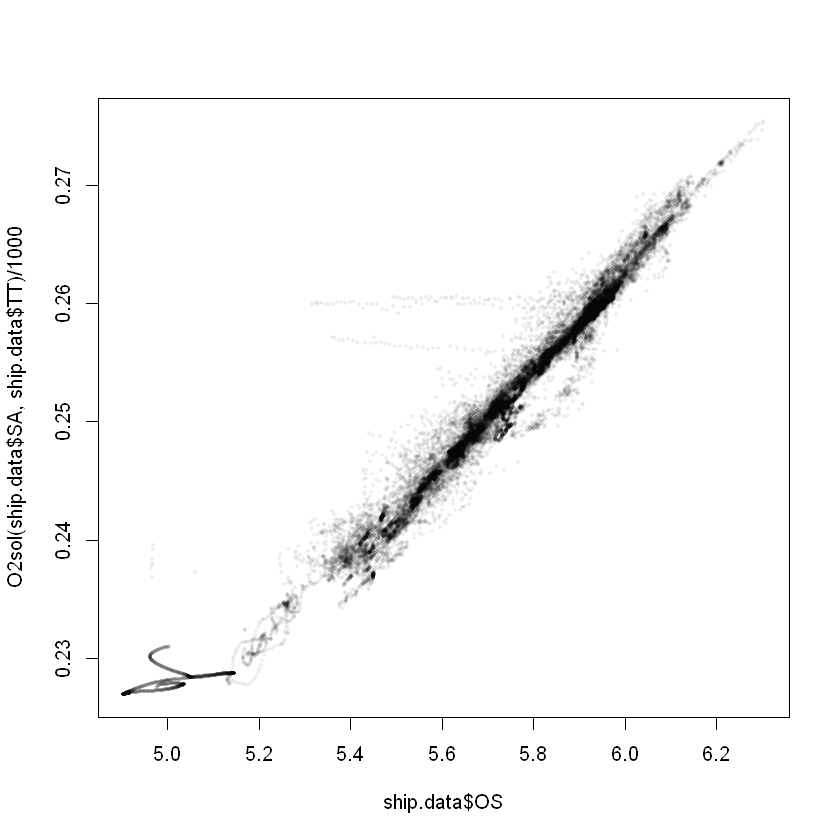

In [13]:
plot(ship.data$OS, O2sol(ship.data$SA, ship.data$TT)/1000, pch=16, cex=0.4, col='#00000010')

In [14]:
#### Calcualtes density from S and T (Massel 2015)
rho = function(S=30, T=15, p=0) {
    a.0 = 999.842594
    a.1 = 6.793953e-2
    a.2 = -9.095290e-3
    a.3 = 1.001685e-4
    a.4 = -1.120083e-6
    a.5 = 6.536332e-9
    rho.smow = a.0 + a.1*T + a.2*T^2 + a.3*T^3 + a.4*T^4 + a.5*T^5
    
    b.0 = 8.2449e-1
    b.1 = -4.0899e-3
    b.2 = 7.6438e-5
    b.3 = -8.2467e-7
    b.4 = 5.3875e-9
    B.1 = b.0 + b.1*T + b.2*T^2 + b.3*T^3 + b.4*T^4
    
    c.0 = -5.7246e-3
    c.1 = 1.0227e-4
    c.2 = -1.6546e-6
    d.0 = 4.8314e-4
    C.1 = c.0 + c.1*T + c.2*T^2
    
    rho = rho.smow + B.1 * S + C.1 * S^1.5 + d.0 * S^2
    rho
}

# NCP Calculation

In [15]:
# NCP in mmol O2 m-2 d-1; seawater density in kg m-3, O2sol in microL kg-1
#ncp = (ship.data$O2.Ar/100) * (O2sol(ship.data$SA, ship.data$TT) / 1000) * ship.data$sw_dens0(salt, temp) * wpv;

calc.ncp = function(o2ar, o2ar.cal, S, T, k) {
    ncp = (o2ar / o2ar.cal - 1) * O2sol(S, T) / 1000 * rho(S, T) * k
}

ship.data$BOS.EIMS = ship.data$EIMS.O2.Ar / ship.data$EIMS.O2.Ar.cal - 1
ship.data$NCP.EIMS = calc.ncp(ship.data$EIMS.O2.Ar, ship.data$EIMS.O2.Ar.cal, ship.data$SA,
                              ship.data$TT, ship.data$k)

ship.data$BOS.MIMS = ship.data$MIMS.O2.Ar / ship.data$MIMS.O2.Ar.cal - 1
ship.data$NCP.MIMS = calc.ncp(ship.data$MIMS.O2.Ar, ship.data$MIMS.O2.Ar.cal, ship.data$SA,
                              ship.data$TT, ship.data$k)

ship.data = ship.data[!is.na(ship.data$NCP.EIMS),]
ship.data = ship.data[!is.na(ship.data$NCP.MIMS),]
ship.data = ship.data[!is.na(ship.data$BOS.EIMS),]
ship.data = ship.data[!is.na(ship.data$BOS.MIMS),]

# Preliminary Review

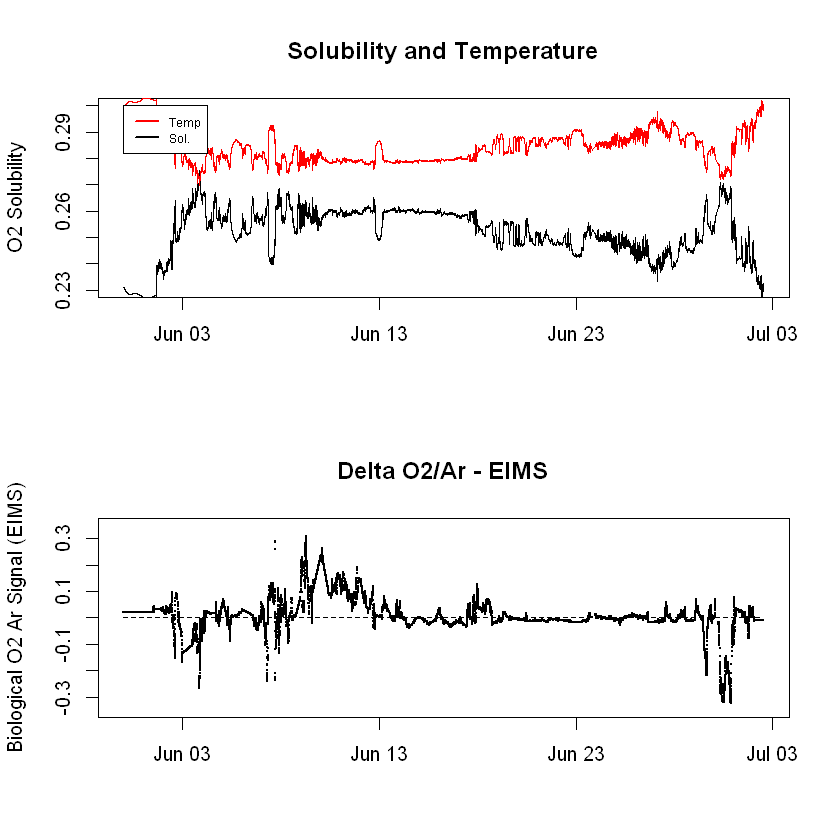

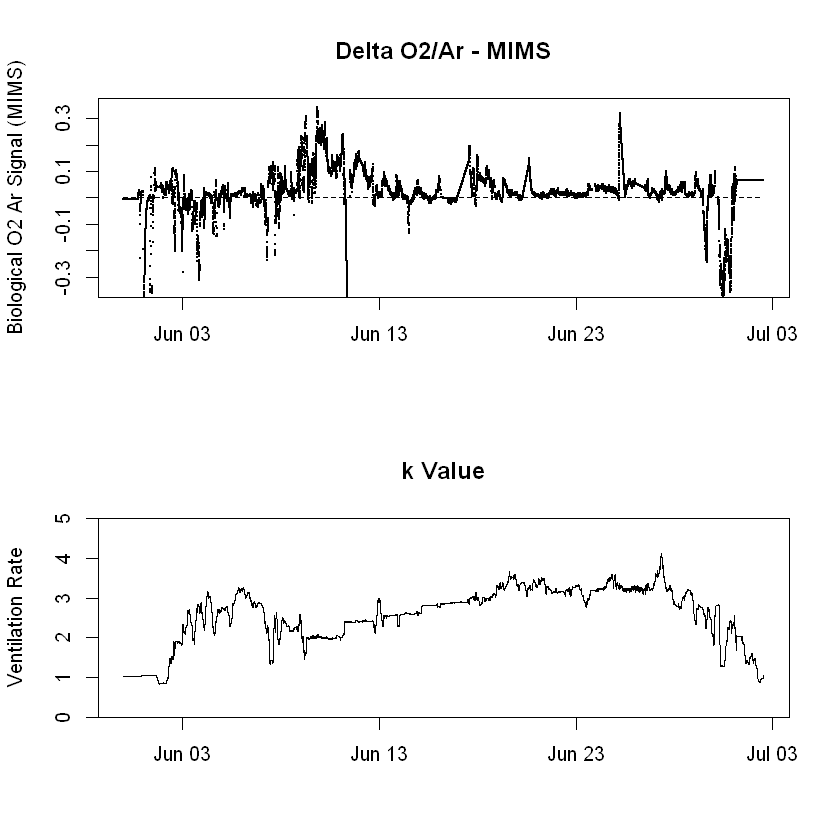

null device 
          1

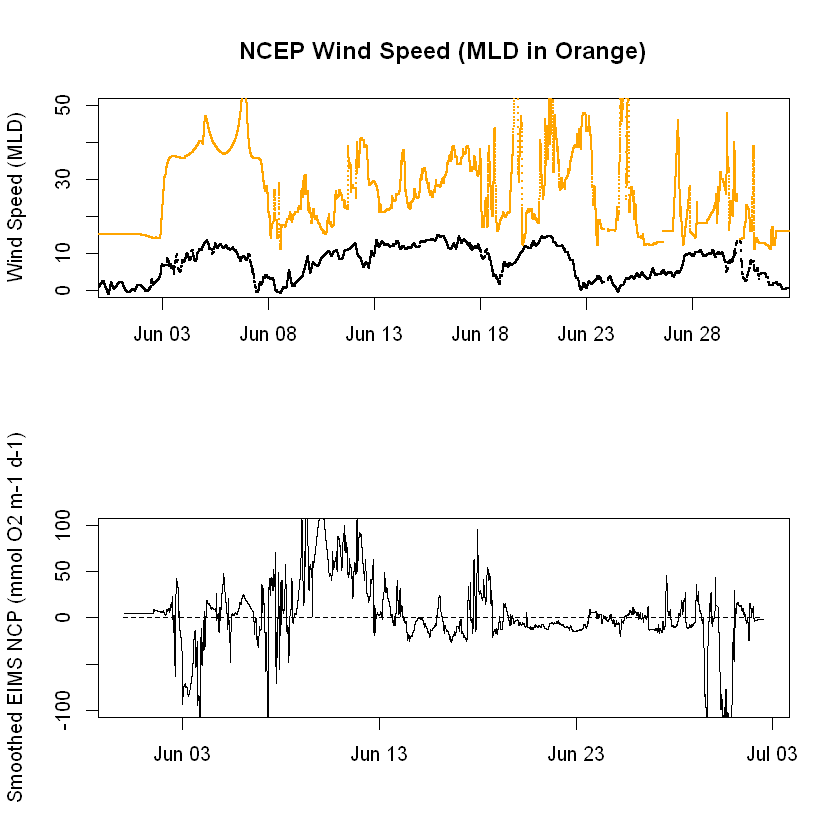

In [16]:
#pdf('Output/NCP Module - NCP Diagnostics.pdf')

par(mfrow=c(2,1))

################################
## O2 solubility and temperature
################################
plot(ship.data$DT, O2sol(ship.data$SA, ship.data$TT) / 1000, type='l', ylab='O2 Solubility',
     ylim=c(0.23, 0.30), xlab='', main='Solubility and Temperature')
#add.daynight()
lines(ship.data$DT, ship.data$TT/300 + 0.235, col='red', lwd=1)
legend(ship.data$DT[1], 0.30, c('Temp', 'Sol.'), col=c('red', 'black'), cex=0.6, lwd=2)

################################
## Biological O2 argon singal
################################
plot(ship.data$DT, ship.data$BOS.EIMS, pch=20, cex=0.1, ylab='Biological O2 Ar Signal (EIMS)', xlab='',
     main='Delta O2/Ar - EIMS', ylim=c(-0.35, 0.35))
#add.daynight()
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0, 0), lty=2)


plot(ship.data$DT,  ship.data$BOS.MIMS, pch=20, cex=0.1, ylab='Biological O2 Ar Signal (MIMS)', xlab='',
     main='Delta O2/Ar - MIMS', ylim=c(-0.35, 0.35))
#add.daynight()
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0, 0), lty=2)

################################
## Wind speed and k values
################################
plot(ship.data$DT, ship.data$k, type='l', ylab='Ventilation Rate', main='k Value', xlab='', yaxs='i', ylim=c(0,5))
#add.daynight()

plot(ship.data$DT, ship.data$NCEP, ylim=c(0, 50), pch=20, cex=0.1, xaxs='i', ylab='Wind Speed (MLD)',
     xlab='', main='NCEP Wind Speed (MLD in Orange)')
points(ship.data$DT, ship.data$MLD, col='orange', pch=20, cex=0.1)
#legend(ship.data$DT[1], 10, c('K', 'Wind'), col=c('black', 'red'), cex=0.6, lwd=2)

################################
## NCP plot (smoothed)
################################
plot(ship.data$DT, ma(ship.data$NCP.EIMS, 25), type='l', ylab='Smoothed EIMS NCP (mmol O2 m-1 d-1)',
     ylim=c(-100, 100), xlab='')
#add.daynight()
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0, 0), lty=2)


plot(ship.data$DT, ma(ship.data$NCP.MIMS, 25), type='l', ylab='Smoothed MIMS NCP (mmol O2 m-1 d-1)',
     ylim=c(-100, 100), xlab='')
#add.daynight()
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0, 0), lty=2)


dev.off()

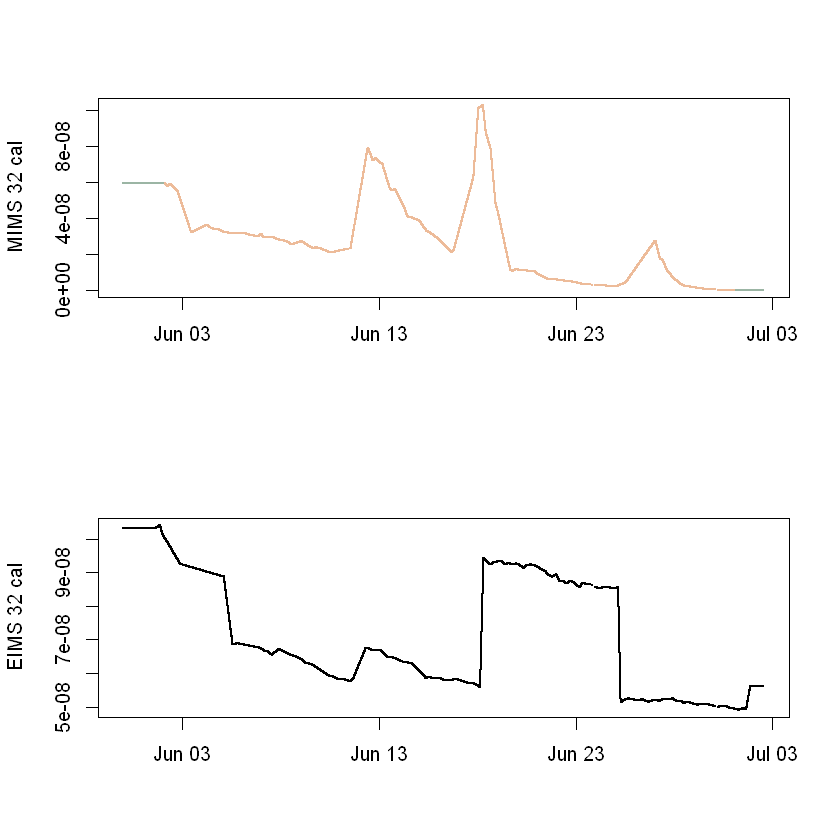

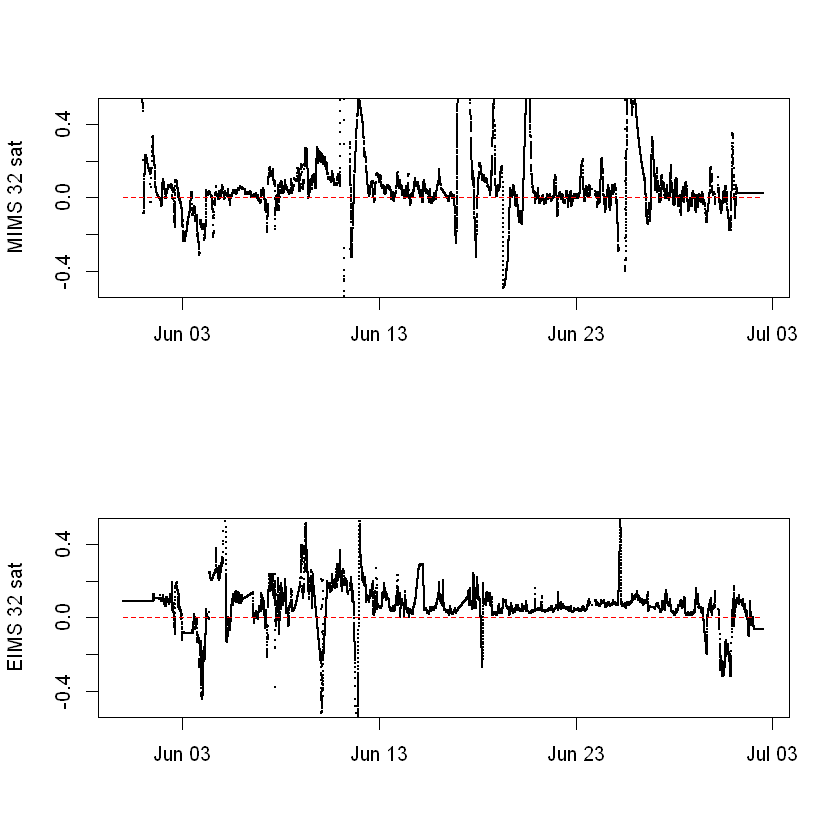

In [46]:
par(mfrow=c(2,1))

plot(ship.data$DT,runmed(ship.data$MIMS.32.cal, 31), pch=20, cex=0.1, ylab='MIMS 32 cal',
     xlab='', col = get.qual.pal(5)[ship.data$MIMS.32.cal.FLAG])

plot(ship.data$DT,runmed(ship.data$EIMS.32.cal, 31), pch=20, cex=0.1, ylab='EIMS 32 cal',
     xlab='')

plot(ship.data$DT, runmed(ship.data$MIMS.32, 31) / runmed(ship.data$MIMS.32.cal, 31) - 1, pch=20, cex=0.1, ylab='MIMS 32 sat',
     xlab='', ylim=c(-.5,.5))
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0,0), lty=2, col='red')

plot(ship.data$DT, ship.data$EIMS.32 / ship.data$EIMS.32.cal - 1, pch=20, cex=0.1, ylab='EIMS 32 sat',
     xlab='', ylim=c(-0.5,0.5))
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0,0), lty=2, col='red')

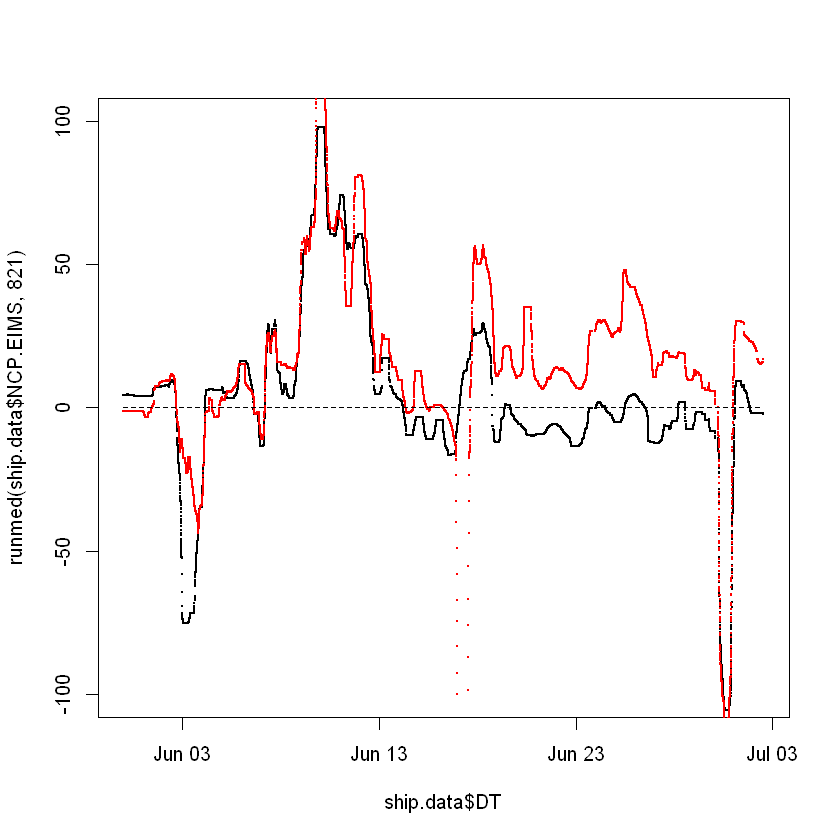

In [20]:
plot(ship.data$DT, runmed(ship.data$BOS.EIMS, 821), pch=16, cex=0.2, ylim=c(-100,100), ylab='Biological Oxygen Signal',
     xlab='')

points(ship.data$DT, runmed(ship.data$BOS.MIMS, 811), pch=16, cex=0.2, col='red')
#points(ship.data$DT, runmed(ship.data$NCP.MIMS2, 2011), pch=16, cex=0.2, col='blue')
lines(c(ship.data$DT[1], max(ship.data$DT)), c(0,0), lty=2)

In [18]:
unique(ship.data$Cycle)

[1] "Cycle0"             "SeaSoar1"           "Transect1"         
 [4] "MVP Transect 1"     "Cycle1"             "MVP Transect 3"    
 [7] "Cycle2"             "MVP Transect 4"     "Transect2"         
[10] "MVP Transect 5"     "Cycle3"             "Bowtie 1"          
[13] "Transect3"          "Bowtie 2"           "Cycle4"            
[16] "SeaSoar2"           "BBL"                "Santa Cruz Basin 1"
[19] "TransComp"          "Santa Cruz Basin 2"

In [2]:
#pdf('Output/NCP Module - Spatial NCP (MIMS, z2, SS1).pdf')
#png('Output/NCP Module - Spatial NCP (MIMS, z2, SS1).png')

l = which(ship.data$Cycle %in% c('SeaSoar2'))

col = make.div.pal2(runmed(ship.data$NCP.MIMS[l], 21), 100, min = -50, max = 150)

plot.map(ship.data$LO[l], ship.data$LA[l], col = col, main='Preliminary NCP Values', zoom = 2, cex = 1.5)

## Legend
points(x = rep(-120, 101), y = seq(35, 37, 1/50), col=get.div.pal(101), pch=16, cex=1.5)
text(-119.6, 37, '150 mmol O2 m-2 d-1')
text(-119.6, 35, '-50 mmol O2 m-2 d-1')

dev.off()

ERROR: Error in ship.data$Cycle %in% c("SeaSoar2"): object 'ship.data' not found


In [11]:
#save(ship.data, file='./RStates/ship.ncp.2min.rdata')
save(ship.data, file='./RStates/ship.ncp.30min.rdata')
#write.xlsx(ship.data, file='./Input Data/Shipdata - NCP.xlsx')

In [27]:
for (i in unique(ship.data$Cycle)) {
    l = which(ship.data$Cycle == i)
    write.xlsx(ship.data[l,], file = paste0('Output/Ship.data Output - ', i, '.xlsx'))
}

In [36]:
summary(ship.data$LO)
#Sys.setenv("R_ZIPCMD" = "C:/RBuildTools/3.4/bin/zip.exe")

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -123.9  -122.7  -122.0  -121.6  -121.2  -117.2 

# Cycles Analysis

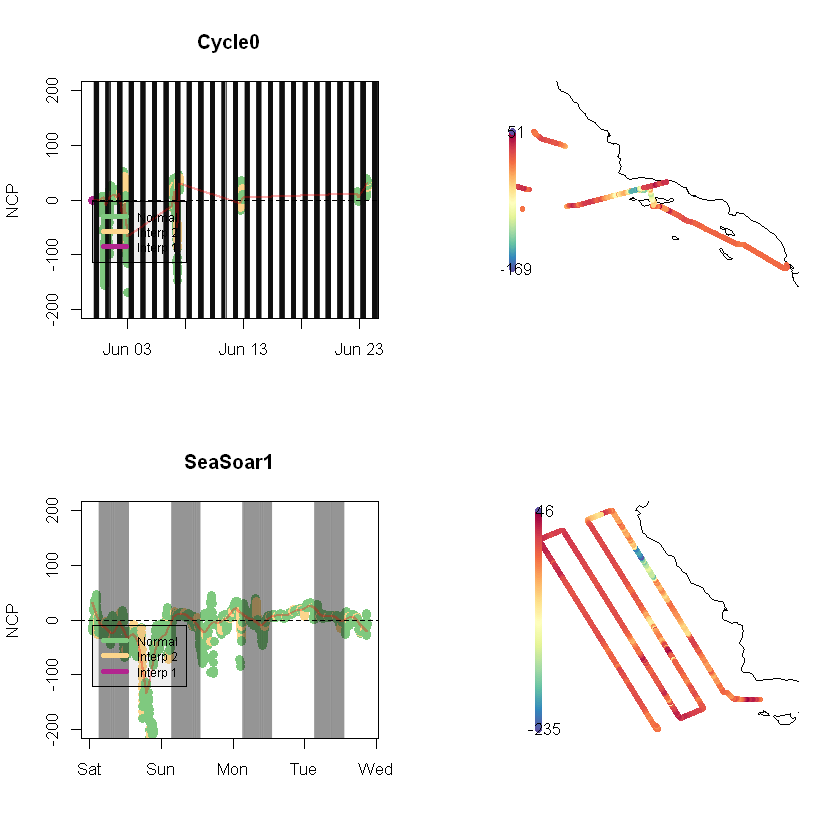

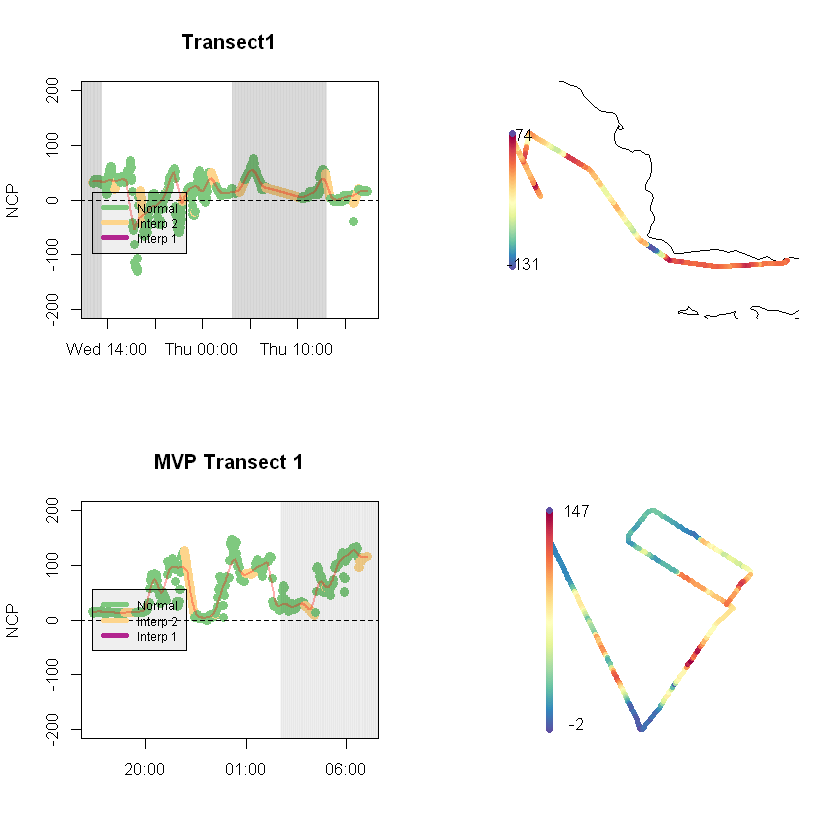

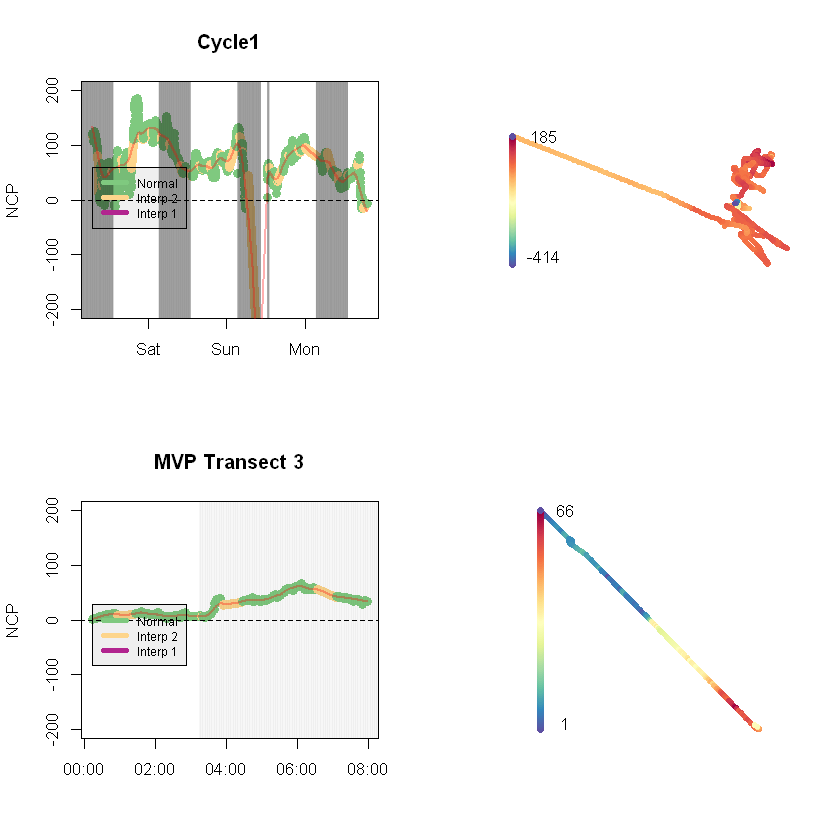

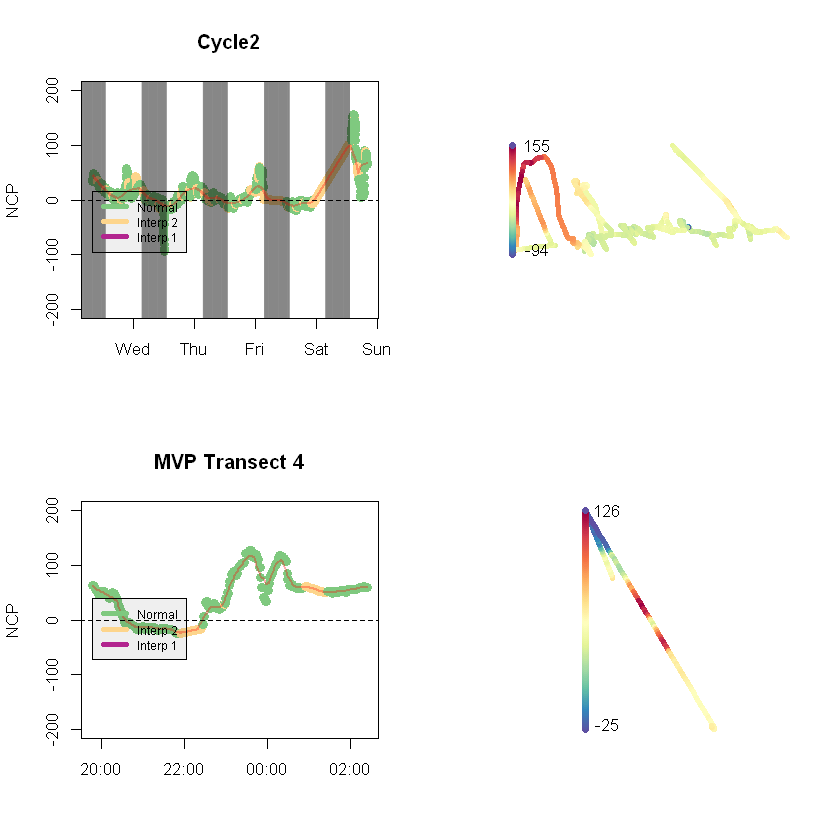

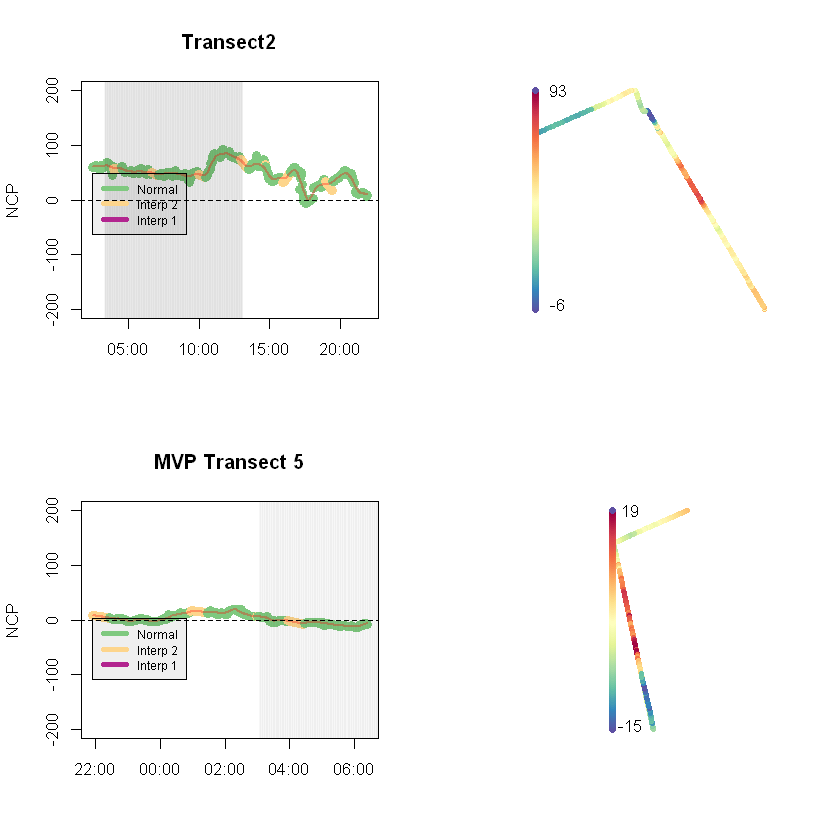

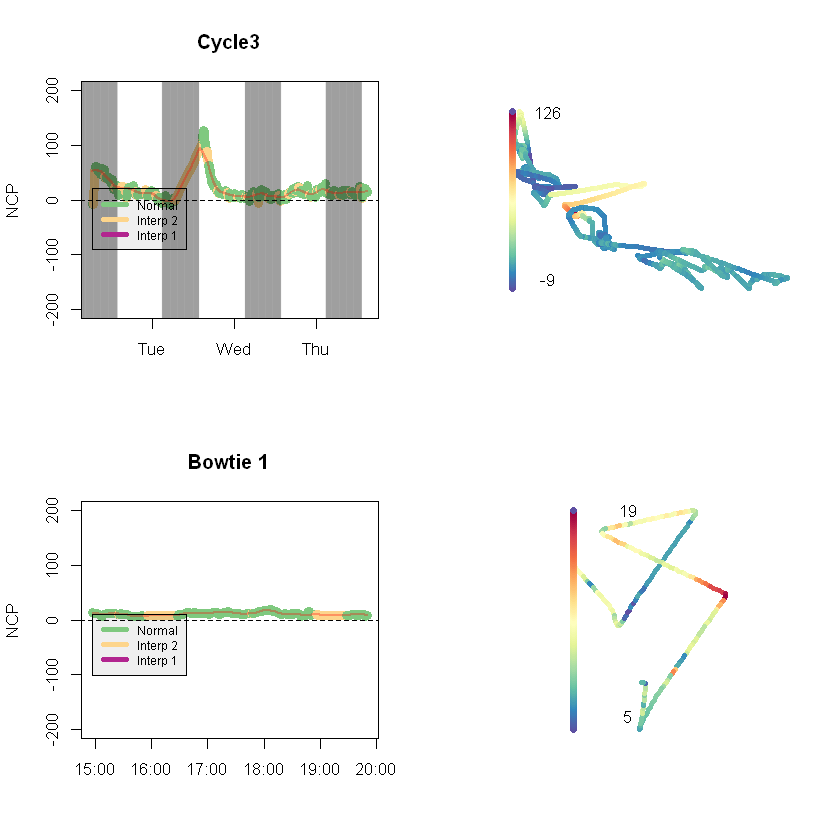

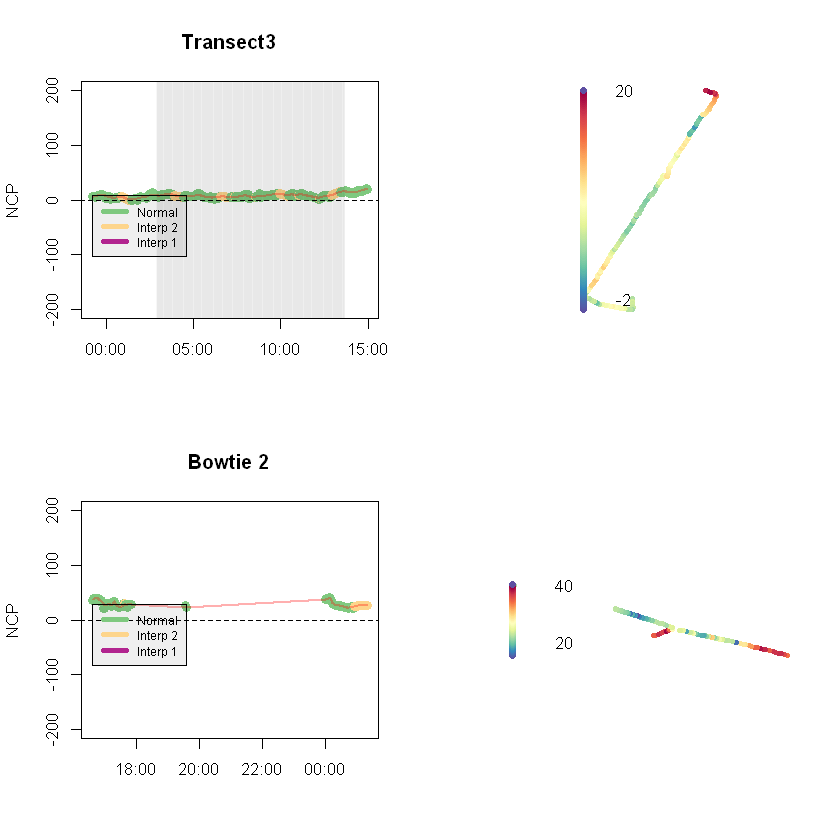

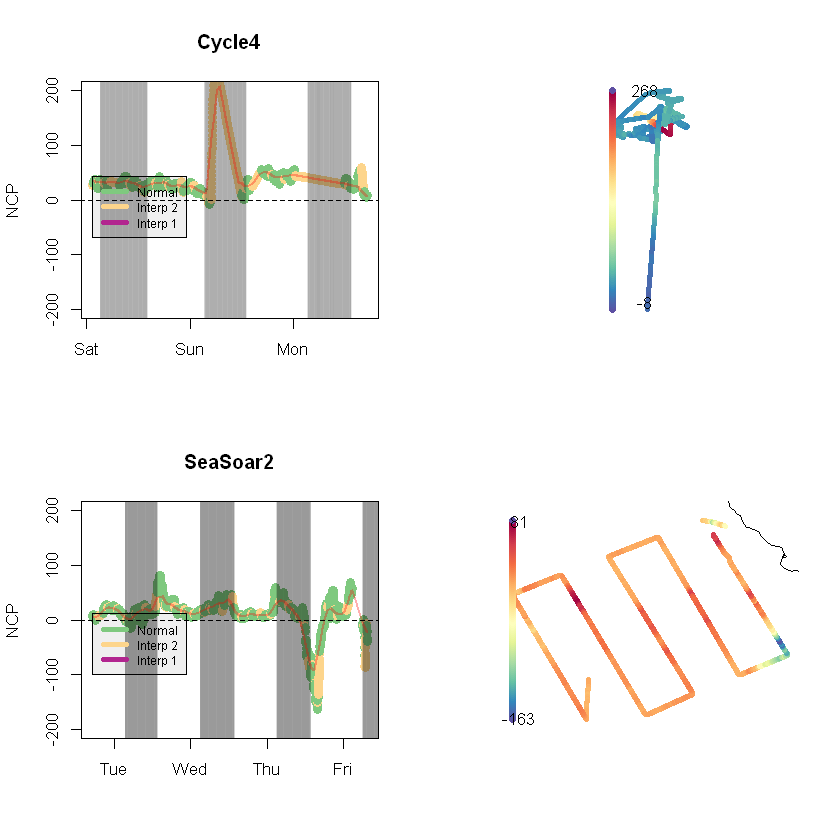

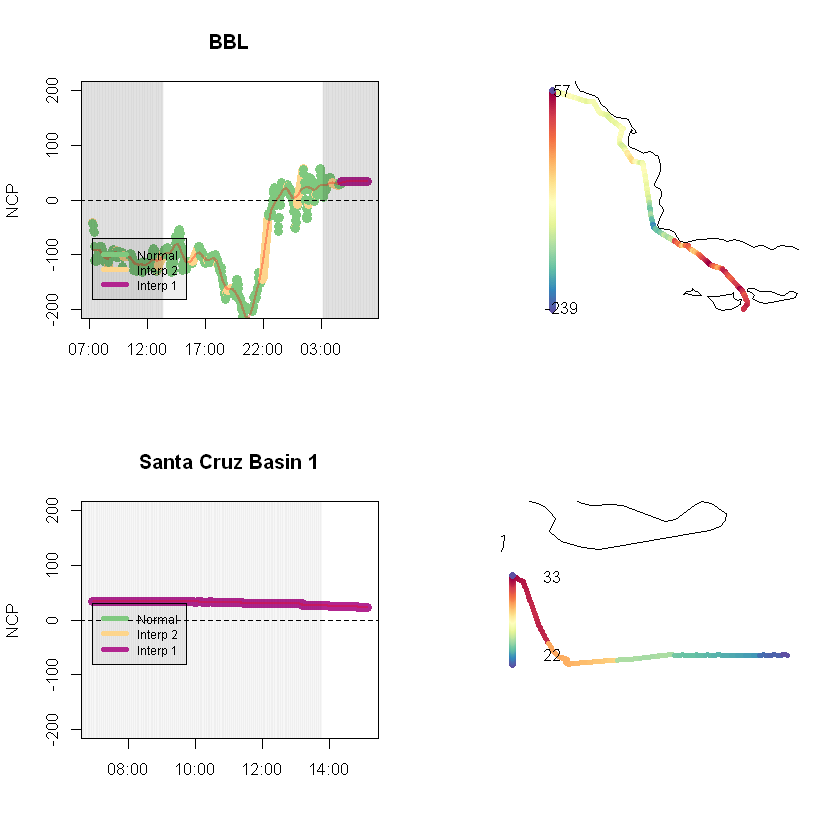

pdf 
  3

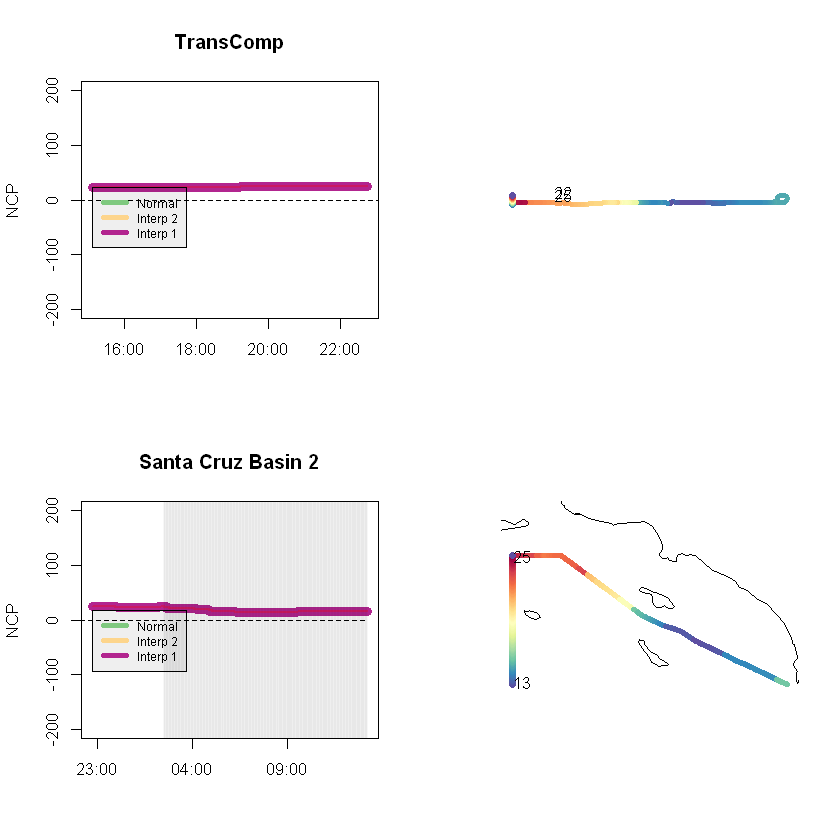

In [55]:
#pdf('Output/NCP Module - NCP Cycles Preliminary.pdf')

par(mfrow=c(2,2))

for (i in unique(ship.data$Cycle)) {
    l = which(ship.data$Cycle == i)
    
    ## Set colors
    col = make.div.pal(ship.data$NCP.MIMS[l], 110)
    flag.col = get.qual.pal(n = 4)
    
    ##########################
    ## Plot the Timesseries ##
    ##########################
    plot(ship.data$DT[l], ship.data$NCP.MIMS[l], main=i, pch=16, cex=1.2, lwd=2,
         ylab='NCP', xlab='', col=flag.col[ship.data$MIMS.O2.Ar.FLAG[l]], ylim=c(-200,200))
    
    add.daynight('#00000008')
    
    ## Add trendline and legend
    mod = lowess(x = ship.data$DT[l], ship.data$NCP.MIMS[l], f = 0.05)
    lines(mod, col='#ff000050', lwd=2)
    lines(x=c(min(ship.data$DT), max(ship.data$DT)), y= c(0, 0), lty=2) # Zero line
    legend(ship.data$DT[l[1]], mean(ship.data$NCP.MIMS[l]), c('Normal', 'Interp 2', 'Interp 1'),
           col=flag.col[1:3], cex=0.7, lwd=4, bg='#00000010')
    
    
    #########################
    ## Plot Spatial Extent ##
    #########################
    plot.map(ship.data$LO[l], ship.data$LA[l], col=col)
    points(x = rep(min(ship.data$LO[l]), 101), y = seq(min(ship.data$LA[l]), max(ship.data$LA[l]), length.out=101),
           col=get.div.pal(100), pch=16)
    text(min(ship.data$LO[l])+0.08, max(ship.data$LA[l]), floor(max(ship.data$NCP.MIMS[l])))
    text(min(ship.data$LO[l])+0.08, min(ship.data$LA[l])+0.02, floor(min(ship.data$NCP.MIMS[l])))
}

dev.off()

In [56]:
#pdf('Output/NCP Module - NCP Cycles Preliminary pt2.pdf')

par(mfrow=c(2,2))

for (i in unique(ship.data$Cycle)) {
    l = which(ship.data$Cycle == i)
    #l = l[ship.data$NCP[l] > -10000 & ship.data$NCP[l] < 10000]
    
    ## Set colors
    col = make.div.pal(ship.data$k[l], 100)
    flag.col = get.qual.pal(4)
    
    ######################
    ## Plot Time series ##
    ######################
    plot(ship.data$DT[l], ship.data$EIMS.O2.Ar[l], main=i, pch=16, cex=1.2, lwd=2, ylab='O2:Ar', xlab='',
        col=flag.col[ship.data$EIMS.O2.Ar.FLAG[l]])
    add.daynight('#00000004')
    
    ## Add trendline and legend
    mod = lowess(x = ship.data$DT[l], ship.data$EIMS.O2.Ar[l], f = 0.05)
    lines(mod, col='#ff0000', lwd=1)
    legend(ship.data$DT[l[1]], max(ship.data$EIMS.O2.Ar[l]), c('Normal', 'Interp 2', 'Interp 1'),
           col=flag.col[1:3], cex=0.6, lwd=4, bg='#00000010')
    
    col = make.div.pal(ship.data$NCP.MIMS[l], 110)
    
     #########################
    ## Plot Spatial Extent ##
    #########################
    plot.map(ship.data$LO[l], ship.data$LA[l], col=col)
    points(x = rep(min(ship.data$LO[l]), 101), y = seq(min(ship.data$LA[l]), max(ship.data$LA[l]), length.out=101),
           col=get.div.pal(100), pch=16)
    text(min(ship.data$LO[l])+0.08, max(ship.data$LA[l]), floor(max(ship.data$NCP.MIMS[l])))
    text(min(ship.data$LO[l])+0.08, min(ship.data$LA[l])+0.02, floor(min(ship.data$NCP.MIMS[l])))
}

dev.off()

png 
  2

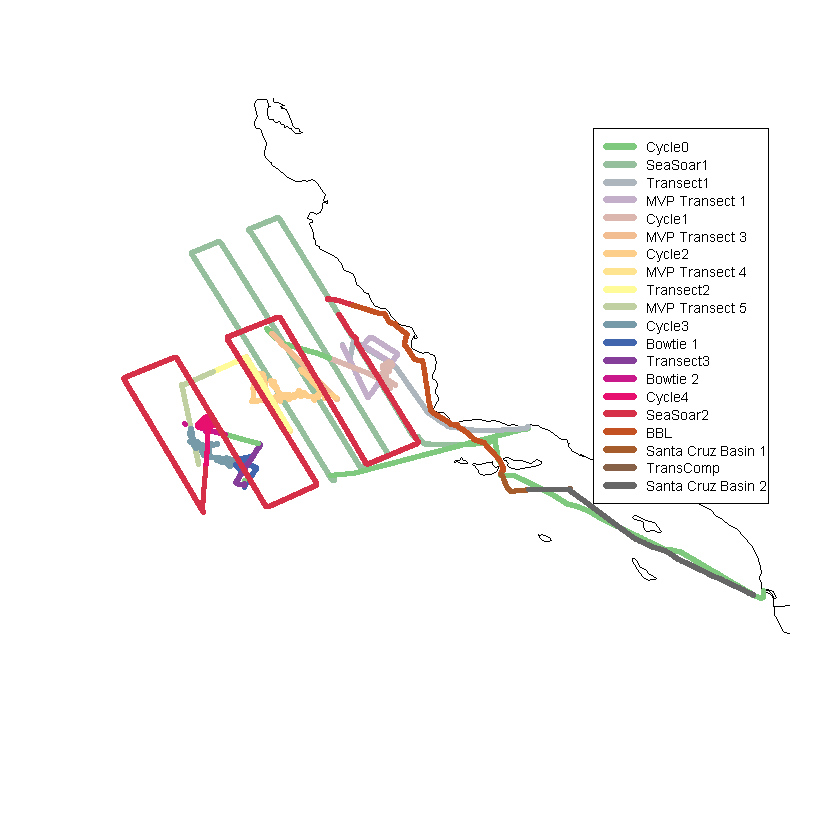

In [32]:
#png('Output/NCP Module - Cycle Map.png')

col = get.qual.pal(length(unique(ship.data$Cycle)))
cols = sapply(ship.data$Cycle, function(x) {which(unique(ship.data$Cycle) == x)})

plot.map(ship.data$LO, ship.data$LA, col=col[cols], pch=16, cex = 0.6)
legend(-119, 37.5, c(unique(ship.data$Cycle)), col=col[unique(cols)], lwd=6, cex=0.7)

#dev.off()

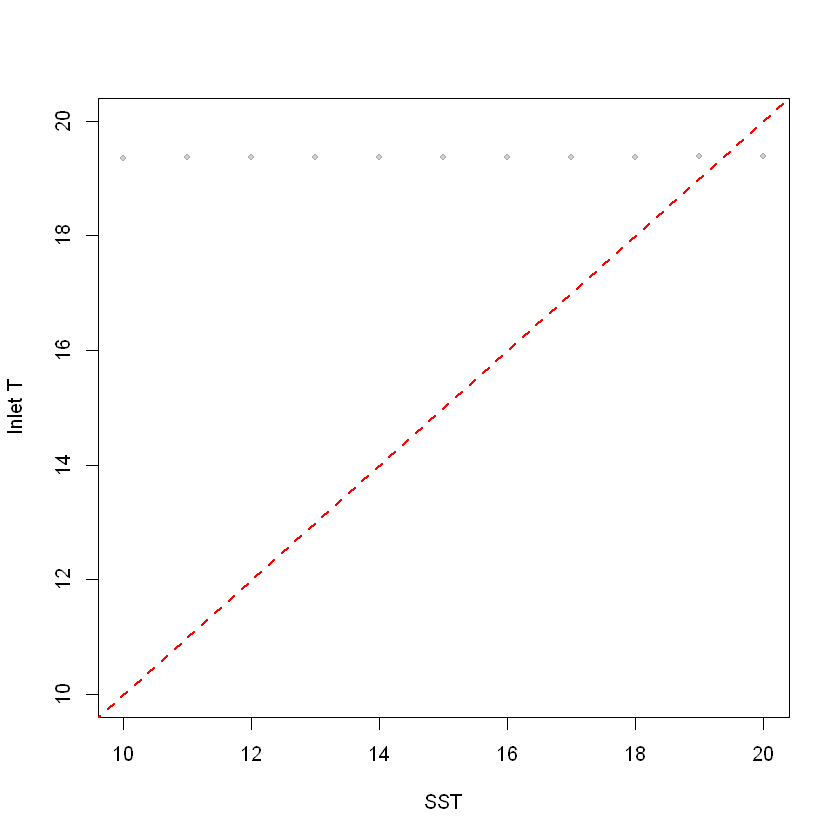

In [33]:
plot(ship.data$TT, ship.data$Inlet.T, pch=20, xlim=c(10,20), ylim=c(10,20), col='#00000030',
     ylab='Inlet T', xlab='SST')

lines(c(0,100), c(0, 100), col='red', lty=2, lwd=2)